#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

請根據 Lena 圖做以下處理

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

In [1]:
!pip install opencv-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('data/lena.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Hint: 矩形

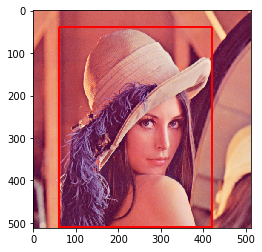

In [22]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (255, 0, 0), 3)
plt.imshow(img_rect)

# while True:
#     cv2.imshow('image', img_rect)
#     k = cv2.waitKey(0)
#     if k == 27:
#         cv2.destroyAllWindows()
#         break

## Hint: 線

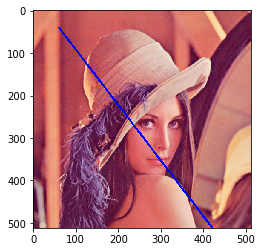

In [12]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 3)
plt.imshow(img_line)

# while True:
#     cv2.imshow('image', img_line)
#     k = cv2.waitKey(0)
#     if k == 27:
#         cv2.destroyAllWindows()
#         break

## Hint: 文字

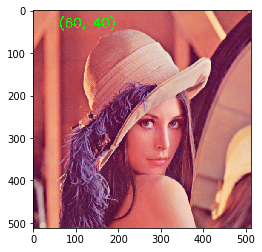

In [14]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (0, 255, 0), 2)
plt.imshow(img_text)

# while True:
#     cv2.imshow('image', img_text)
#     k = cv2.waitKey(0)
#     if k == 27:
#         cv2.destroyAllWindows()
#         break

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

M_scale.shape=(2, 3), bbox.shape=(2, 2)
origin point1=[452, 40], origin point2=[92, 510]
resize point1=(226, 20), resize point2=(46, 255)


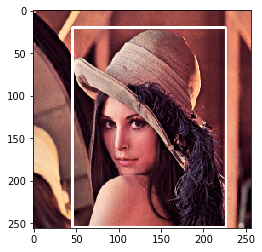

In [25]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.imread('data/lena.png')
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[:,:,2] = cv2.equalizeHist(img_hw[:,:,2])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2RGB)

"""
水平鏡像
"""
# h, w = img_hw.shape[:2]

# 圖片鏡像
img_hw = img_hw[:,::-1, :]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1[0] = 512 - point1[0] # 右上
point2[0] = 512 - point2[0] # 左下

"""
縮放處理 (0.5 倍)
"""
fx = 0.5
fy = 0.5
resize_col = int(img_hw.shape[1]*fx)
resize_row = int(img_hw.shape[0]*fy)

#建構 scale matrix
M_scale = np.array([[0.5, 0, 0],
                    [0, 0.5, 0]], dtype = np.float32)
img_hw = cv2.warpAffine(img_hw, M_scale, (resize_col, resize_row), borderValue = (0, 0, 0))

#把左上跟右下轉為矩陣型式
bbox = np.array((point1, point2), dtype=np.float32)
print('M_scale.shape={}, bbox.shape={}'.format(M_scale.shape, bbox.shape))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
homo_coor_result = np.dot(M_scale.T, bbox)
homo_coor_result = homo_coor_result.astype('uint8')

#print(homo_coor_result)
scale_point1 = tuple(homo_coor_result[0])
scale_point2 = tuple(homo_coor_result[1])
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

# 畫圖
cv2.rectangle(img_hw, scale_point1, scale_point2, (255, 255, 255), 2)
plt.imshow(img_hw)

# while True:
#     cv2.imshow('image', img_hw)
#     k = cv2.waitKey(0)
#     if k == 27:
#         cv2.destroyAllWindows()
#         break

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional

origin point1=(60, 40), origin point2=(420, 510)
resize point1=(46, 20), resize point2=(225, 254)


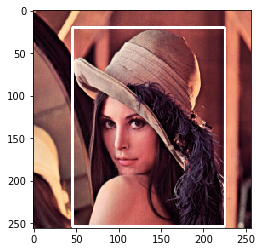

In [38]:
img_hw = img.copy()
point1 = (60, 40)
point2 = (420, 510)

# 2D mask
img_mask = np.zeros_like(img_hw)
img_mask[40:510, 60:420, :] = 255

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_RGB2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[:, :, -1] = cv2.equalizeHist(img_hw[:, :, -1])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2RGB)

"""
水平鏡像 + 縮放處理 (0.5 倍)
"""
# 水平鏡像 (圖片)
img_hw = img_hw[:, ::-1, :]
img_mask = img_mask[:, ::-1, :]

# 縮放處理
img_hw = cv2.resize(img_hw, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
img_mask = cv2.resize(img_mask, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

# 取得遮照的左上跟右下的點
# 這邊你可以發現 transformation matrix 跟雙線性差值的結果會有一點點差異
all_h_coor, all_w_coor, all_c_coor = np.where(img_mask)
scale_point1 = (min(all_w_coor), min(all_h_coor))
scale_point2 = (max(all_w_coor), max(all_h_coor))
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

"""
畫出人物矩形邊框
"""
cv2.rectangle(img_hw, scale_point1, scale_point2, (255, 255, 255), 2)
plt.imshow(img_hw)

# while True:
#     cv2.imshow('image', img_hw)
#     k = cv2.waitKey(0)
#     if k == 27:
#         cv2.destroyAllWindows()
#         break